# 0. Data Backup from InfluxDB

Imports

In [4]:
from influxdb_client_3 import InfluxDBClient3
import pandas as pd  
import pyarrow.parquet as pq
from pathlib import Path
import argparse
import math
from dataclasses import dataclass 
from typing import Optional, Dict, List, Tuple 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In this part we perform the Data Backup from influxDB. As a result, sparced dataset with raw data stored in folder 'influxDB Backup' in root folder of this repository. File format: parquet. 


In [ ]:
LIMIT = 1_000_000

client = InfluxDBClient3(
    token="apiv3_9EL5Mq-kpLIFd1y3dc9ow0JWWnGPMLM9h6lcFQxQt02FZ-SZis7eJYmj27-E8EKlA_3MTUGa_QBd0holy94oEQ",
    host="http://10.65.1.77:10102",
    database="spp1-main"
)

TABLE_NAME = "saw"
OUTPUT_FILE = "influxDB Backup/saw.backup.parquet"

offset = 0
all_frames = [] # List to store each chunk in memory

print(f"Starting export of '{TABLE_NAME}'...")

while True:
    print(f"Fetching rows {offset} to {offset + LIMIT}...", end="\r")

    # Order by time is critical to ensure pages don't shuffle or overlap
    query = f"""
        SELECT * FROM "{TABLE_NAME}" 
        ORDER BY time ASC
        LIMIT {LIMIT} OFFSET {offset}
    """

    try:
        # Fetch the chunk
        df_chunk = client.query(query=query, mode="pandas")

        # If chunk is empty, we are done
        if df_chunk.empty:
            print(f"\nNo more data found after offset {offset}.")
            break
        
        # Append to our in-memory list
        all_frames.append(df_chunk)

        # Check if this was the last page (less rows than limit)
        if len(df_chunk) < LIMIT:
            print(f"\nReached end of dataset at offset {offset + len(df_chunk)}.")
            break

        # Prepare for next iteration
        offset += LIMIT

    except Exception as e:
        print(f"\nCRITICAL ERROR at offset {offset}: {e}")
        # Depending on importance, you might want to 'break' or 'raise' here
        break

# --- Final Consolidation ---
if all_frames:
    print("Concatenating data...")
    final_df = pd.concat(all_frames, ignore_index=True)

    print(f"Saving {len(final_df)} rows to {OUTPUT_FILE}...")
    final_df.to_parquet(OUTPUT_FILE, index=False)
    print("Export successful.")
else:
    print("No data was retrieved.")

Starting export of 'saw'...
Fetching rows 0 to 1000000...
CRITICAL ERROR at offset 0: Error while executing query: Flight returned unavailable error, with message: failed to connect to all addresses; last error: UNKNOWN: ipv4:10.65.1.77:10102: tcp handshaker shutdown. gRPC client debug context: UNKNOWN:Error received from peer  {created_time:"2026-01-04T21:28:30.562623+01:00", grpc_status:14, grpc_message:"failed to connect to all addresses; last error: UNKNOWN: ipv4:10.65.1.77:10102: tcp handshaker shutdown"}. Client context: IOError: Server never sent a data message. Detail: Internal
No data was retrieved.


Parquet to csv

In [ ]:
in_path = Path("influxDB Backup/saw.backup.parquet")
out_path = in_path.with_suffix(".csv")

df = pq.read_table(in_path).to_pandas()
df.to_csv(out_path, index=False)

print("Saved to:", out_path.resolve())
print("Exists:", out_path.exists(), "Size:", out_path.stat().st_size if out_path.exists() else None)


Saved to: /Users/vvsmbk/Desktop/all/3 semester classes/Smart Production and Prototyping/Practical Part/gitProject/projectRaphael/influxDB Backup/saw.backup.csv
Exists: True Size: 7143765


"Compression" of the raw csv file: after that step, all the waterflow presented data reorganized in wide format

In [21]:
df = pd.read_csv("influxDB Backup/saw.backup.csv")

df["time"] = pd.to_datetime(df["time"])
df["time_1s"] = df["time"].dt.floor("s")   # .dt.round("s") for rounding

value_cols = [c for c in df.columns if c not in ("time", "time_1s")]

out = (
    df.sort_values("time")
      .groupby("time_1s")[value_cols]
      .last()                      # last not-NaN for each column
      .reset_index()
      .rename(columns={"time_1s": "time"})
)

out.to_csv("influxDB Backup/saw_wide.csv", index=False)


# 1. Data understanding
In that phase data from the dataset is described. 

1.1. Data structure + Missing values review + Numeric & categorical summaries

In [27]:
import pandas as pd

df = pd.read_csv("influxDB Backup/saw_wide.csv")  # or pd.read_parquet("influxDB Backup/saw.backup.parquet")

# --- Data structure overview ---
rows, cols = df.shape
mem_mb = df.memory_usage(deep=True).sum() / (1024 ** 2)
dup_cnt = int(df.duplicated().sum())
dup_pct = (dup_cnt / rows * 100) if rows else 0.0

print("=== DATASET OVERVIEW ===")
print(f"Rows: {rows}")
print(f"Columns: {cols}")
print(f"Memory (MB): {mem_mb:.2f}")
print(f"Duplicate rows: {dup_cnt} ({dup_pct:.2f}%)")

overview = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "non_null": df.notna().sum(),
    "null": df.isna().sum(),
    "null_percentage": (df.isna().mean() * 100).round(2),
    "unique_not_null": df.nunique(dropna=True),
}).sort_values(["null_percentage", "unique_not_null"], ascending=[False, False])

print("\n=== COLUMNS OVERVIEW (sorted by missing %) ===")
print(overview.to_string())

# --- Missing values report ---
missing_only = overview[overview["null"] > 0][["null", "null_percentage"]].copy()

print("\n=== MISSING VALUES REPORT ===")
if missing_only.empty:
    print("No missing values found.")
else:
    print(missing_only.to_string())

# --- Numeric & categorical summaries ---
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("\n=== NUMERIC SUMMARY ===")
if not numeric_cols:
    print("No numeric columns found.")
else:
    num_summary = df[numeric_cols].describe().T
    num_summary["missing"] = df[numeric_cols].isna().sum()
    num_summary["missing_pct"] = (df[numeric_cols].isna().mean() * 100).round(2)
    print(num_summary.to_string())

print("\n=== CATEGORICAL SUMMARY (top values) ===")
if not categorical_cols:
    print("No categorical columns found.")
else:
    for col in categorical_cols:
        print(f"\n-- {col} --")
        s = df[col]
        print(f"dtype: {s.dtype}")
        print(f"missing: {int(s.isna().sum())} ({(s.isna().mean()*100):.2f}%)")
        print(f"unique (non-null): {int(s.nunique(dropna=True))}")
        top = s.value_counts(dropna=True).head(10)
        if top.empty:
            print("No non-null values.")
        else:
            print("Top 10 values:")
            print(top.to_string())


=== DATASET OVERVIEW ===
Rows: 20738
Columns: 8
Memory (MB): 3.00
Duplicate rows: 0 (0.00%)

=== COLUMNS OVERVIEW (sorted by missing %) ===
                      dtype  non_null  null  null_percentage  unique_not_null
machineRunning       object     17991  2747            13.25                2
feedRateActual      float64     18485  2253            10.86               16
bandVelocityActual  float64     18654  2084            10.05               22
microphoneRMS       float64     20705    33             0.16            20698
vibrationRMS        float64     20705    33             0.16            20654
currentRMS          float64     20707    31             0.15            20697
temperatureRMS      float64     20708    30             0.14            18173
time                 object     20738     0             0.00            20738

=== MISSING VALUES REPORT ===
                    null  null_percentage
machineRunning      2747            13.25
feedRateActual      2253            10.86
b

1.2. Correlations with currentRMS + Heatmap

=== CORRELATION MATRIX (Spearman) ===
                    bandVelocityActual  currentRMS  feedRateActual  microphoneRMS  temperatureRMS  vibrationRMS
bandVelocityActual            1.000000    0.702108        0.980992       0.680166       -0.424205      0.680865
currentRMS                    0.702108    1.000000        0.698748       0.474267       -0.213580      0.474633
feedRateActual                0.980992    0.698748        1.000000       0.677071       -0.418530      0.680815
microphoneRMS                 0.680166    0.474267        0.677071       1.000000       -0.692241      0.847683
temperatureRMS               -0.424205   -0.213580       -0.418530      -0.692241        1.000000     -0.730882
vibrationRMS                  0.680865    0.474633        0.680815       0.847683       -0.730882      1.000000


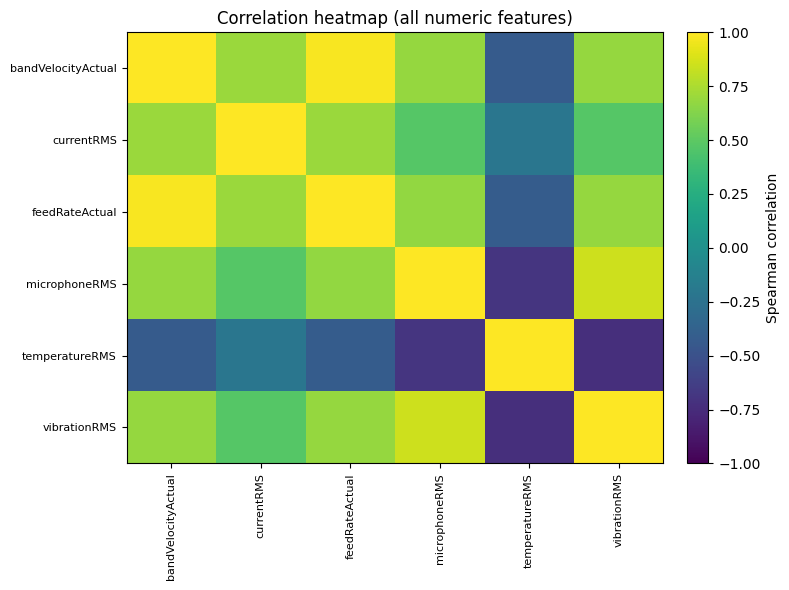

In [ ]:
# numeric columns only
num_df = df.select_dtypes(include=["number"]).copy()

# correlation matrix (choose: "pearson" or "spearman")
corr = num_df.corr(method="spearman")

print("=== CORRELATION MATRIX (Spearman) ===")
print(corr.to_string())

# heatmap (all vs all)
cols = corr.columns.tolist()
data = corr.values

plt.figure(figsize=(max(8, len(cols) * 0.5), max(6, len(cols) * 0.5)))
im = plt.imshow(data, aspect="auto", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label="Spearman correlation")

plt.xticks(np.arange(len(cols)), cols, rotation=90, fontsize=8)
plt.yticks(np.arange(len(cols)), cols, fontsize=8)

plt.title("Correlation heatmap (all numeric features)")
plt.tight_layout()
plt.show()

1.3. Target relationships + simple hypothesis tests

In [33]:
target = "currentRMS"

# --- split columns ---
numeric_cols = df.select_dtypes(include=["number"]).columns.drop(target, errors="ignore")
categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns

print("=== TARGET RELATIONSHIPS: currentRMS ===")

# -------------------------------------------------
# Numeric features vs target (Spearman correlation)
# -------------------------------------------------
print("\n--- Numeric features (Spearman correlation) ---")

num_results = []

for col in numeric_cols:
    x = pd.to_numeric(df[col], errors="coerce")
    y = pd.to_numeric(df[target], errors="coerce")
    mask = x.notna() & y.notna()

    if mask.sum() < 30:
        continue

    corr, p = stats.spearmanr(x[mask], y[mask])
    num_results.append((col, corr, p, mask.sum()))

num_results = sorted(num_results, key=lambda x: abs(x[1]), reverse=True)

for col, corr, p, n in num_results:
    print(f"{col:25s} | corr={corr: .3f} | p-value={p:.2e} | n={n}")


=== TARGET RELATIONSHIPS: currentRMS ===

--- Numeric features (Spearman correlation) ---
bandVelocityActual        | corr= 0.702 | p-value=0.00e+00 | n=18628
feedRateActual            | corr= 0.699 | p-value=0.00e+00 | n=18458
vibrationRMS              | corr= 0.475 | p-value=0.00e+00 | n=20684
microphoneRMS             | corr= 0.474 | p-value=0.00e+00 | n=20683
temperatureRMS            | corr=-0.214 | p-value=4.55e-212 | n=20691


1.4. Distributions/boxplots/scatters for key columns


=== 1) Target distribution over time ===



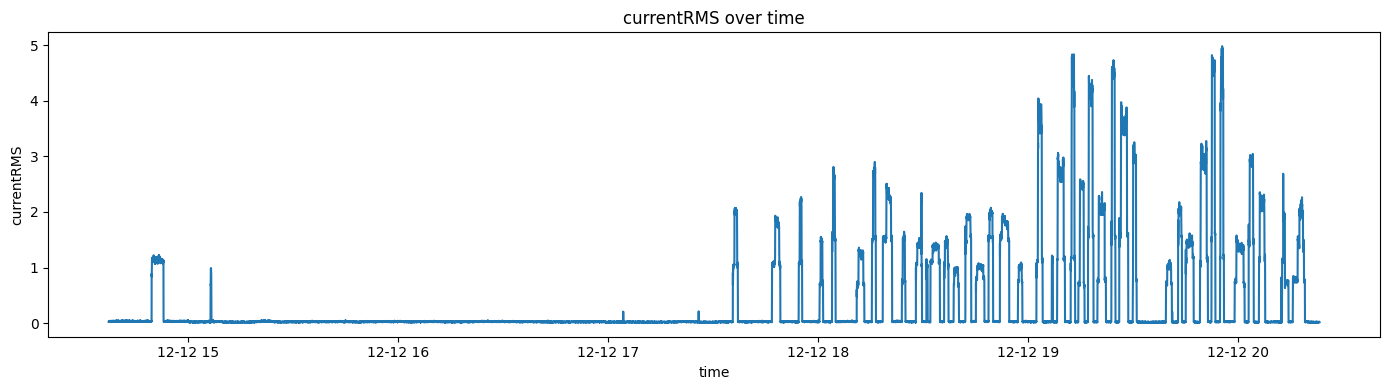


=== 2) Scatter: feedRateActual vs currentRMS ===



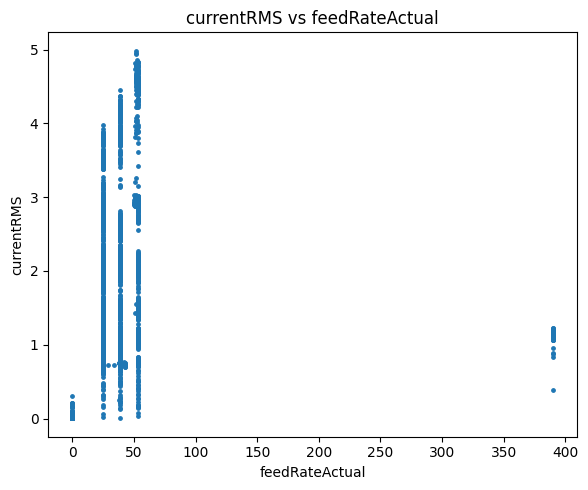


=== 3) Scatter: bandVelocityActual vs currentRMS ===



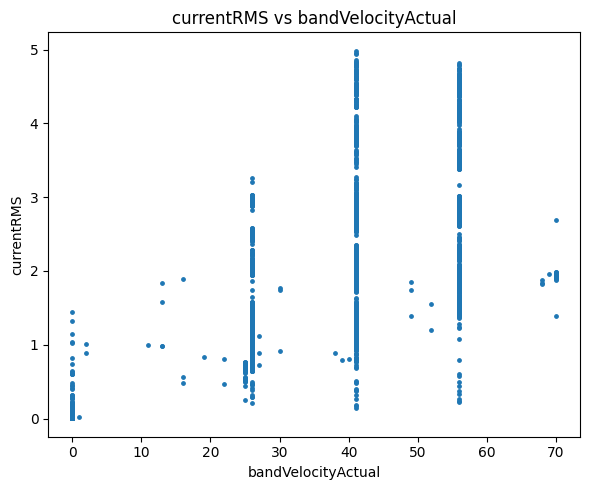


=== 4) Boxplots (binned X vs currentRMS) ===



/var/folders/vr/x31lnzv90c31vt1v756mjwv00000gn/T/ipykernel_14832/3242030977.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g[target].values for _, g in tmp.groupby("bin")]
/var/folders/vr/x31lnzv90c31vt1v756mjwv00000gn/T/ipykernel_14832/3242030977.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labels = [str(k) for k, _ in tmp.groupby("bin")]


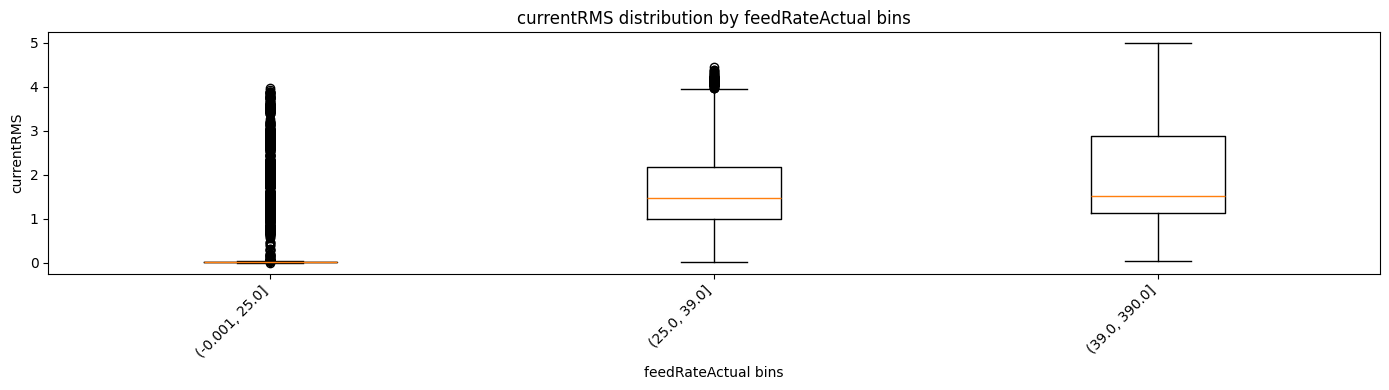

/var/folders/vr/x31lnzv90c31vt1v756mjwv00000gn/T/ipykernel_14832/3242030977.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g[target].values for _, g in tmp.groupby("bin")]
/var/folders/vr/x31lnzv90c31vt1v756mjwv00000gn/T/ipykernel_14832/3242030977.py:60: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labels = [str(k) for k, _ in tmp.groupby("bin")]


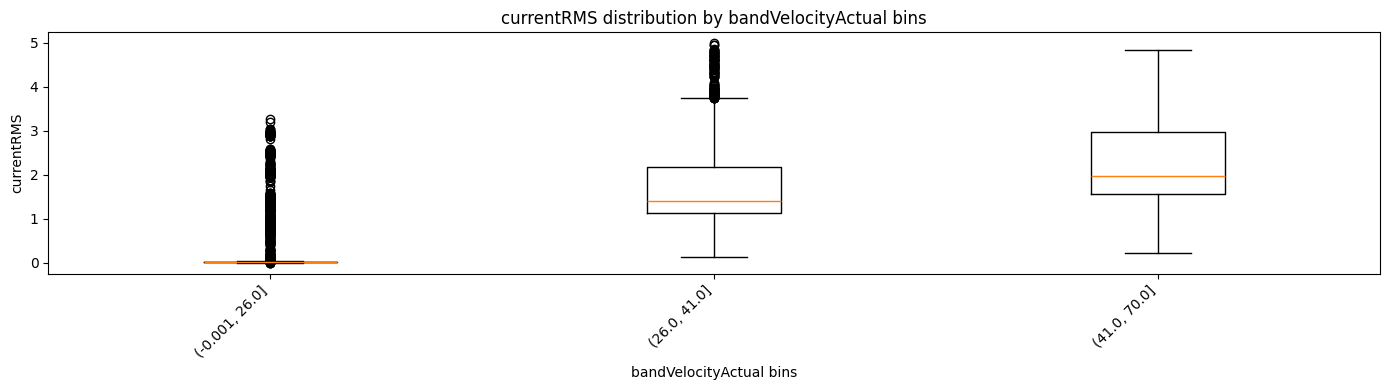

In [35]:
# --- columns ---
time_col = "time"
target = "currentRMS"
x1 = "feedRateActual"
x2 = "bandVelocityActual"

# --- preparation ---
df_plot = df[[time_col, target, x1, x2]].copy()
df_plot[time_col] = pd.to_datetime(df_plot[time_col], errors="coerce")

for c in [target, x1, x2]:
    df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")

df_plot = df_plot.dropna(subset=[time_col]).sort_values(time_col)


print("\n=== 1) Target distribution over time ===\n")

plt.figure(figsize=(14, 4))
plt.plot(df_plot[time_col], df_plot[target])
plt.title(f"{target} over time")
plt.xlabel("time")
plt.ylabel(target)
plt.tight_layout()
plt.show()

print("\n=== 2) Scatter: feedRateActual vs currentRMS ===\n") 

plt.figure(figsize=(6, 5))
mask = df_plot[[x1, target]].notna().all(axis=1)
plt.scatter(df_plot.loc[mask, x1], df_plot.loc[mask, target], s=6)
plt.title(f"{target} vs {x1}")
plt.xlabel(x1)
plt.ylabel(target)
plt.tight_layout()
plt.show()

print("\n=== 3) Scatter: bandVelocityActual vs currentRMS ===\n") 

plt.figure(figsize=(6, 5))
mask = df_plot[[x2, target]].notna().all(axis=1)
plt.scatter(df_plot.loc[mask, x2], df_plot.loc[mask, target], s=6)
plt.title(f"{target} vs {x2}")
plt.xlabel(x2)
plt.ylabel(target)
plt.tight_layout()
plt.show()

print("\n=== 4) Boxplots (binned X vs currentRMS) ===\n")

def boxplot_binned(x_col: str, bins: int = 10):
    tmp = df_plot[[x_col, target]].dropna()
    if tmp.empty:
        print(f"No data for {x_col}")
        return

    tmp["bin"] = pd.qcut(tmp[x_col], q=min(bins, tmp[x_col].nunique()), duplicates="drop")

    groups = [g[target].values for _, g in tmp.groupby("bin")]
    labels = [str(k) for k, _ in tmp.groupby("bin")]

    plt.figure(figsize=(14, 4))
    plt.boxplot(groups, showfliers=True)
    plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha="right")
    plt.title(f"{target} distribution by {x_col} bins")
    plt.xlabel(f"{x_col} bins")
    plt.ylabel(target)
    plt.tight_layout()
    plt.show()


boxplot_binned(x1, bins=10)
boxplot_binned(x2, bins=10)


1.x. Experiments, performed on 12.12 in Smart Lab printed. 

In [38]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)            
pd.set_option("display.max_colwidth", None)    

df = pd.read_excel("Experiments Band Saw 12.12 simplified.xlsx")
print(df.to_string(index=False))

 Experiment No  Piece No Material Timestamp Start Timestamp End Time Diff  Material thickness (mm)  Feed Rate  Band Speed  Setup Code (for the machine operator) Avg Current         Result                                                                                                              Comments
             1         1    steel        18:36:05      18:36:57  00:00:52                     29.2         39          41                                      1         2.1         Success                                                                             Vibration Sensor moved closer to the saw
             2         1    steel        18:47:41      18:48:50  00:01:09                     29.2         25          41                                      2         1.8         Success                                                                                                                  NaN
             3         1    steel        18:54:43      18:55:17  00:00:34         

# 2. Experiments (?)

Try 1. Drop False values for machine running and keep the rest for datarobot.

In [3]:
in_file = "influxDB Backup/saw_wide.csv"
out_file = "influxDB Backup/saw_wide_maschineRunning_true.csv"

df = pd.read_csv(in_file)

# machineRunning can be bool, "True"/"False" strings, 1/0, or NaN
mr = df["machineRunning"]

mask_true = (
    (mr == True) |
    (mr.astype(str).str.strip().str.lower() == "true") |
    (pd.to_numeric(mr, errors="coerce") == 1)
)

df[mask_true].to_csv(out_file, index=False)

print(f"Saved {mask_true.sum()} rows to: {out_file}")

Saved 3741 rows to: influxDB Backup/saw_wide_maschineRunning_true.csv


Join of columns "experiment No", "Piece No" and "Material" to the dataset saw_wide_maschineRunning_true for time series identifecation

code v1

In [13]:
import pandas as pd
import numpy as np

# paths
exp_path = "Experiments Band Saw 12.12 simplified.xlsx"
saw_path = "influxDB Backup/saw_wide_maschineRunning_true.csv"
out_path = "influxDB Backup/saw_wide_maschineRunning_true_joined.csv"

fixed_date = pd.Timestamp("2025-12-12")
KEY_ATOL = 0.01   # допуск для сравнения Feed Rate / Band Speed (можешь сделать 0.001 или 0.1 при необходимости)

# -----------------------------
# load + clean columns
# -----------------------------
exp = pd.read_excel(exp_path)
saw = pd.read_csv(saw_path)

exp.columns = exp.columns.str.strip()
saw.columns = saw.columns.str.strip()

# -----------------------------
# saw time_cmp: only time-of-day, +1 hour, ms precision
# -----------------------------
saw_time_full = pd.to_datetime(saw["time"], errors="coerce")
tod = saw_time_full - saw_time_full.dt.normalize()
saw["time_cmp"] = (fixed_date + tod + pd.Timedelta(hours=1)).dt.floor("ms")

# -----------------------------
# normalize saw numeric keys + scaling feedRateActual (>100 /10) AND keep it
# -----------------------------
saw["feedRateActual"] = pd.to_numeric(saw["feedRateActual"], errors="coerce")
saw["bandVelocityActual"] = pd.to_numeric(saw["bandVelocityActual"], errors="coerce")

mask_scale = saw["feedRateActual"] > 100
saw.loc[mask_scale, "feedRateActual"] = saw.loc[mask_scale, "feedRateActual"] / 10.0

saw["Feed Rate"]  = saw["feedRateActual"].astype("float64")
saw["Band Speed"] = saw["bandVelocityActual"].astype("float64")

# -----------------------------
# experiments timestamps (HH:MM:SS -> fixed date, ms precision)
# -----------------------------
exp["Timestamp Start"] = pd.to_datetime(
    fixed_date.strftime("%Y-%m-%d") + " " + exp["Timestamp Start"].astype(str),
    errors="coerce"
).dt.floor("ms")

exp["Timestamp End"] = pd.to_datetime(
    fixed_date.strftime("%Y-%m-%d") + " " + exp["Timestamp End"].astype(str),
    errors="coerce"
).dt.floor("ms")

m = exp["Timestamp End"] < exp["Timestamp Start"]
exp.loc[m, "Timestamp End"] += pd.Timedelta(days=1)

# experiment numeric keys
exp["Feed Rate"]  = pd.to_numeric(exp["Feed Rate"], errors="coerce").astype("float64")
exp["Band Speed"] = pd.to_numeric(exp["Band Speed"], errors="coerce").astype("float64")
exp["Material thickness (mm)"] = pd.to_numeric(exp["Material thickness (mm)"], errors="coerce")

# -----------------------------
# create output columns (empty by default)
# -----------------------------
saw["Experiment No"] = pd.NA
saw["Piece No"] = pd.NA
saw["Material thickness (mm)"] = pd.NA
saw["Material"] = pd.NA

# rows where matching is allowed
valid_saw = (
    saw["time_cmp"].notna() &
    saw["Feed Rate"].notna() & saw["Band Speed"].notna() &
    (saw["Feed Rate"] != 0) & (saw["Band Speed"] != 0)
)

# -----------------------------
# main logic:
# for each experiment -> fill all saw rows where (keys ~ match) AND time in [start,end]
# values will repeat through the whole interval
# -----------------------------
exp_iter = exp.dropna(subset=["Timestamp Start", "Timestamp End", "Feed Rate", "Band Speed"]).copy()
exp_iter = exp_iter.sort_values("Timestamp Start")

matched_any = {}  # for diagnostics

for _, r in exp_iter.iterrows():
    key_match = (
        valid_saw &
        (np.abs(saw["Feed Rate"]  - r["Feed Rate"])  <= KEY_ATOL) &
        (np.abs(saw["Band Speed"] - r["Band Speed"]) <= KEY_ATOL)
    )

    time_match = (saw["time_cmp"] >= r["Timestamp Start"]) & (saw["time_cmp"] <= r["Timestamp End"])

    mask = key_match & time_match

    matched_any[int(r["Experiment No"])] = bool(mask.any()) if pd.notna(r["Experiment No"]) else bool(mask.any())

    # ВАЖНО: НЕ ограничиваем isna() — заполняем все строки в интервале
    saw.loc[mask, "Experiment No"] = int(r["Experiment No"]) if pd.notna(r["Experiment No"]) else pd.NA
    saw.loc[mask, "Piece No"] = int(r["Piece No"]) if pd.notna(r["Piece No"]) else pd.NA
    saw.loc[mask, "Material thickness (mm)"] = r["Material thickness (mm)"]
    saw.loc[mask, "Material"] = r["Material"] if pd.notna(r["Material"]) else pd.NA

# -----------------------------
# output dtypes + save
# -----------------------------
saw["Experiment No"] = pd.to_numeric(saw["Experiment No"], errors="coerce").astype("Int64")
saw["Piece No"]      = pd.to_numeric(saw["Piece No"], errors="coerce").astype("Int64")
saw["Material thickness (mm)"] = pd.to_numeric(saw["Material thickness (mm)"], errors="coerce")

out = saw.drop(columns=["time_cmp", "Feed Rate", "Band Speed"], errors="ignore")
out.to_csv(out_path, index=False)

# -----------------------------
# quick diagnostics: which experiments found zero matching rows
# -----------------------------
not_matched = [k for k, v in matched_any.items() if not v]
print("Experiments with ZERO matched rows:", not_matched)
print("Saved:", out_path)

out.head(20)


Experiments with ZERO matched rows: [20, 22, 28, 38, 39]
Saved: influxDB Backup/saw_wide_maschineRunning_true_joined.csv


,time,bandVelocityActual,currentRMS,feedRateActual,machineRunning,microphoneRMS,temperatureRMS,vibrationRMS,Experiment No,Piece No,Material thickness (mm),Material
0,2025-12-12 14:49:43,2.0,0.886779,39.0,True,0.074864,24.348553,3.503168,<NA>,<NA>,NaN,<NA>
1,2025-12-12 14:49:44,41.0,0.838384,39.0,True,0.084009,24.357191,4.272558,<NA>,<NA>,NaN,<NA>
2,2025-12-12 14:49:45,41.0,0.876621,39.0,True,0.086972,24.344240,3.908590,<NA>,<NA>,NaN,<NA>
3,2025-12-12 14:49:46,41.0,0.960319,39.0,True,0.072588,24.345861,2.589309,<NA>,<NA>,NaN,<NA>
4,2025-12-12 14:49:47,41.0,1.120628,39.0,True,0.082789,24.327732,2.690249,<NA>,<NA>,NaN,<NA>
5,2025-12-12 14:49:48,41.0,1.120247,39.0,True,0.083010,24.334280,2.763231,<NA>,<NA>,NaN,<NA>
6,2025-12-12 14:49:49,41.0,1.147193,39.0,True,0.098975,24.344542,2.420811,<NA>,<NA>,NaN,<NA>
7,2025-12-12 14:49:50,41.0,1.132911,39.0,True,0.096530,24.349743,3.063124,<NA>,<NA>,NaN,<NA>
8,2025-12-12 14:49:51,41.0,1.138862,39.0,True,0.086716,24.350765,3.795638,<NA>,<NA>,NaN,<NA>
9,2025-12-12 14:49:52,41.0,1.131528,39.0,True,0.083239,24.349628,3.287390,<NA>,<NA>,NaN,<NA>


code v2

In [12]:
import pandas as pd
import numpy as np

# paths
exp_path = "Experiments Band Saw 12.12 simplified.xlsx"
saw_path = "influxDB Backup/saw_wide_maschineRunning_true.csv"
out_path = "influxDB Backup/saw_wide_maschineRunning_true_joined.csv"

fixed_date = pd.Timestamp("2025-12-12")

# -----------------------------
# load + clean columns
# -----------------------------
exp = pd.read_excel(exp_path)
saw = pd.read_csv(saw_path)

exp.columns = exp.columns.str.strip()
saw.columns = saw.columns.str.strip()

# -----------------------------
# prepare saw time for matching (only time-of-day, +1 hour, compare in ms)
# -----------------------------
saw_time_full = pd.to_datetime(saw["time"], errors="coerce")
tod = saw_time_full - saw_time_full.dt.normalize()                 # keeps ms/us
saw["time_cmp"] = (fixed_date + tod + pd.Timedelta(hours=1)).dt.floor("ms")

# -----------------------------
# normalize saw numeric keys + scaling feedRateActual (>100 /10) AND keep it (write back)
# -----------------------------
saw["feedRateActual"] = pd.to_numeric(saw["feedRateActual"], errors="coerce")
saw["bandVelocityActual"] = pd.to_numeric(saw["bandVelocityActual"], errors="coerce")

mask_scale = saw["feedRateActual"] > 100
saw.loc[mask_scale, "feedRateActual"] = saw.loc[mask_scale, "feedRateActual"] / 10.0

# keys used for matching (rounded to avoid float noise, same for both tables)
saw["Feed Rate"]  = saw["feedRateActual"].round(3)
saw["Band Speed"] = saw["bandVelocityActual"].round(3)

# -----------------------------
# prepare experiment timestamps (HH:MM:SS -> fixed date, compare in ms)
# -----------------------------
exp["Timestamp Start"] = pd.to_datetime(
    fixed_date.strftime("%Y-%m-%d") + " " + exp["Timestamp Start"].astype(str),
    errors="coerce"
).dt.floor("ms")

exp["Timestamp End"] = pd.to_datetime(
    fixed_date.strftime("%Y-%m-%d") + " " + exp["Timestamp End"].astype(str),
    errors="coerce"
).dt.floor("ms")

# if end < start => crosses midnight
m = exp["Timestamp End"] < exp["Timestamp Start"]
exp.loc[m, "Timestamp End"] += pd.Timedelta(days=1)

# normalize experiment keys
exp["Feed Rate"] = pd.to_numeric(exp["Feed Rate"], errors="coerce").round(3)
exp["Band Speed"] = pd.to_numeric(exp["Band Speed"], errors="coerce").round(3)
exp["Material thickness (mm)"] = pd.to_numeric(exp["Material thickness (mm)"], errors="coerce")

# -----------------------------
# create output columns (empty by default)
# -----------------------------
saw["Experiment No"] = pd.NA
saw["Piece No"] = pd.NA
saw["Material thickness (mm)"] = pd.NA
saw["Material"] = pd.NA

# rows where we are allowed to assign (otherwise must stay empty)
valid_saw = (
    saw["time_cmp"].notna() &
    saw["Feed Rate"].notna() & saw["Band Speed"].notna() &
    (saw["Feed Rate"] != 0) & (saw["Band Speed"] != 0)
)

# -----------------------------
# main logic (simple + reliable):
# for each experiment row -> fill ALL saw rows where:
#   - keys match AND
#   - time_cmp is inside [start, end]
# this automatically "repeats" values until experiment ends
# -----------------------------
exp_iter = exp.dropna(subset=["Timestamp Start", "Timestamp End", "Feed Rate", "Band Speed"]).copy()
exp_iter = exp_iter.sort_values("Timestamp Start")  # optional, just for determinism

for _, r in exp_iter.iterrows():
    mask = (
        valid_saw &
        (saw["Feed Rate"] == r["Feed Rate"]) &
        (saw["Band Speed"] == r["Band Speed"]) &
        (saw["time_cmp"] >= r["Timestamp Start"]) &
        (saw["time_cmp"] <= r["Timestamp End"])
    )

    # if experiments could overlap on same keys/time, and you want "first match wins":
    mask = mask & saw["Experiment No"].isna()

    saw.loc[mask, "Experiment No"] = int(r["Experiment No"]) if pd.notna(r["Experiment No"]) else pd.NA
    saw.loc[mask, "Piece No"] = int(r["Piece No"]) if pd.notna(r["Piece No"]) else pd.NA
    saw.loc[mask, "Material thickness (mm)"] = r["Material thickness (mm)"]
    saw.loc[mask, "Material"] = r["Material"] if pd.notna(r["Material"]) else pd.NA

# -----------------------------
# output dtypes + cleanup + save
# -----------------------------
saw["Experiment No"] = pd.to_numeric(saw["Experiment No"], errors="coerce").astype("Int64")
saw["Piece No"]      = pd.to_numeric(saw["Piece No"], errors="coerce").astype("Int64")
saw["Material thickness (mm)"] = pd.to_numeric(saw["Material thickness (mm)"], errors="coerce")

out = saw.drop(columns=["time_cmp", "Feed Rate", "Band Speed"], errors="ignore")
out.to_csv(out_path, index=False)

out.head(20)


,time,bandVelocityActual,currentRMS,feedRateActual,machineRunning,microphoneRMS,temperatureRMS,vibrationRMS,Experiment No,Piece No,Material thickness (mm),Material
0,2025-12-12 14:49:43,2.0,0.886779,39.0,True,0.074864,24.348553,3.503168,<NA>,<NA>,NaN,<NA>
1,2025-12-12 14:49:44,41.0,0.838384,39.0,True,0.084009,24.357191,4.272558,<NA>,<NA>,NaN,<NA>
2,2025-12-12 14:49:45,41.0,0.876621,39.0,True,0.086972,24.344240,3.908590,<NA>,<NA>,NaN,<NA>
3,2025-12-12 14:49:46,41.0,0.960319,39.0,True,0.072588,24.345861,2.589309,<NA>,<NA>,NaN,<NA>
4,2025-12-12 14:49:47,41.0,1.120628,39.0,True,0.082789,24.327732,2.690249,<NA>,<NA>,NaN,<NA>
5,2025-12-12 14:49:48,41.0,1.120247,39.0,True,0.083010,24.334280,2.763231,<NA>,<NA>,NaN,<NA>
6,2025-12-12 14:49:49,41.0,1.147193,39.0,True,0.098975,24.344542,2.420811,<NA>,<NA>,NaN,<NA>
7,2025-12-12 14:49:50,41.0,1.132911,39.0,True,0.096530,24.349743,3.063124,<NA>,<NA>,NaN,<NA>
8,2025-12-12 14:49:51,41.0,1.138862,39.0,True,0.086716,24.350765,3.795638,<NA>,<NA>,NaN,<NA>
9,2025-12-12 14:49:52,41.0,1.131528,39.0,True,0.083239,24.349628,3.287390,<NA>,<NA>,NaN,<NA>


# Machine learning

eXtreme Gradient Boosted Trees Regressor with Early Stopping (Poisson Loss). Version with the parameters from datarobot for that model

[0]	valid-rmse:1.00577	valid-poisson-nloglik:1.45479
[10]	valid-rmse:0.88349	valid-poisson-nloglik:1.39203
[20]	valid-rmse:0.81363	valid-poisson-nloglik:1.36090
[30]	valid-rmse:0.73685	valid-poisson-nloglik:1.33062
[40]	valid-rmse:0.67674	valid-poisson-nloglik:1.30943
[50]	valid-rmse:0.61991	valid-poisson-nloglik:1.29176
[60]	valid-rmse:0.57198	valid-poisson-nloglik:1.27835
[70]	valid-rmse:0.52870	valid-poisson-nloglik:1.26723
[80]	valid-rmse:0.49460	valid-poisson-nloglik:1.25928
[90]	valid-rmse:0.46858	valid-poisson-nloglik:1.25347
[100]	valid-rmse:0.44227	valid-poisson-nloglik:1.24802
[110]	valid-rmse:0.41337	valid-poisson-nloglik:1.24246
[120]	valid-rmse:0.39361	valid-poisson-nloglik:1.23879
[130]	valid-rmse:0.37939	valid-poisson-nloglik:1.23623
[140]	valid-rmse:0.36334	valid-poisson-nloglik:1.23346
[150]	valid-rmse:0.34938	valid-poisson-nloglik:1.23113
[160]	valid-rmse:0.34082	valid-poisson-nloglik:1.22968
[170]	valid-rmse:0.33039	valid-poisson-nloglik:1.22797
[180]	valid-rmse:0.32

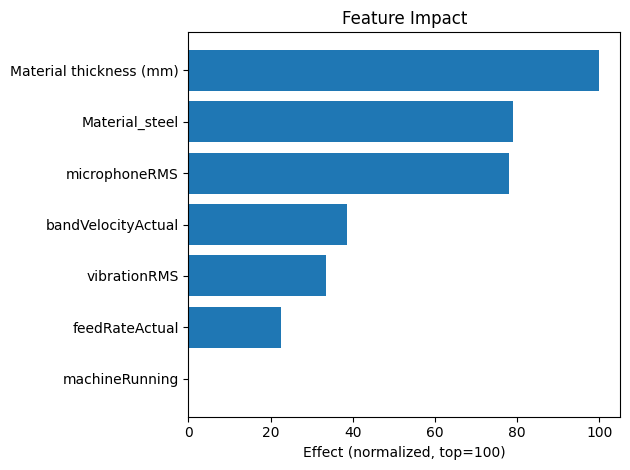

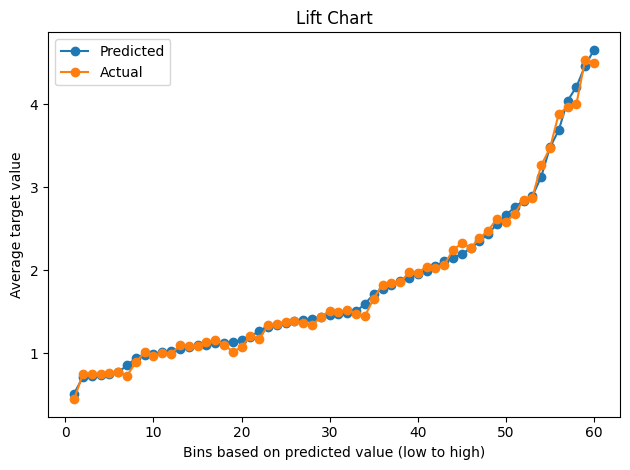

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance

# =========================================================
# 1) Load data (your previously created dataset)
# =========================================================
DATA_PATH = "influxDB Backup/saw_wide_maschineRunning_true_joined.csv"
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

# -------------------------
# Target (CHANGE THIS)
# Poisson requires y >= 0
# -------------------------
TARGET = "currentRMS"  # <-- set your target column here
y = pd.to_numeric(df[TARGET], errors="coerce")

# -------------------------
# Columns to exclude from modeling (PLACEHOLDER requested)
# You can add/remove names here.
# -------------------------
DROP_COLS = ["Experiment No", "Piece No", "time", "temperatureRMS"]

X = df.drop(columns=[TARGET] + [c for c in DROP_COLS if c in df.columns], errors="ignore").copy()

# Keep rows with valid target
m = y.notna()
X = X.loc[m].copy()
y = y.loc[m].copy()

if (y < 0).any():
    raise ValueError("Poisson objective requires target y >= 0 (no negative values).")

# =========================================================
# 2) Minimal preprocessing (DataRobot-like missing_value = -9999)
# =========================================================
MISSING_VALUE = -9999.0

# Convert bool to int
for c in X.columns:
    if X[c].dtype == "bool":
        X[c] = X[c].astype(int)

# One-hot encode categoricals (e.g., Material)
X = pd.get_dummies(X, drop_first=False)

# Coerce to numeric and fill missing with -9999 (so XGBoost 'missing' can use it)
X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan).fillna(MISSING_VALUE)

# =========================================================
# 3) Train/valid split (use 0.25 like DataRobot Stepwise:test_fraction)
# =========================================================
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.25, random_state=1234)
X_tr, X_va = X_tr.align(X_va, axis=1, join="left", fill_value=MISSING_VALUE)

feature_names = list(X_tr.columns)
dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=feature_names, missing=MISSING_VALUE)
dvalid = xgb.DMatrix(X_va, label=y_va, feature_names=feature_names, missing=MISSING_VALUE)

# =========================================================
# 4) DataRobot hyperparameters (NO tuning, fixed)
# NOTE: Some listed fields are DataRobot pipeline options (stacking, ShapFit, etc.)
#       and do not exist as native XGBoost parameters. Here we apply the XGBoost ones.
# =========================================================

# If DataRobot shows multiple values (e.g., "0.02,0.05"), that was a search space there.
# Here we must pick a single value. Set them explicitly:
LEARNING_RATE = 0.02
SUBSAMPLE = 0.7
MAX_DEPTH = 3
COLSAMPLE_BYTREE = 0.5

params = {
    # Core
    "objective": "count:poisson",
    "tree_method": "auto",
    "seed": 1234,

    # "learning_rate"
    "eta": LEARNING_RATE,

    # Structure
    "max_depth": MAX_DEPTH,
    "min_child_weight": 1.0,
    "subsample": SUBSAMPLE,
    "colsample_bytree": COLSAMPLE_BYTREE,
    "colsample_bylevel": 1.0,
    "num_parallel_tree": 1,
    "max_bin": 256,

    # Regularization / split
    "gamma": 0.01,           # DataRobot: min_split_loss
    "lambda": 1.0,           # reg_lambda
    "alpha": 0.0,            # reg_alpha

    # Poisson-specific (DataRobot listed max_delta_step=0.0)
    "max_delta_step": 0.0,

    # Metrics (DataRobot grid metric: RMSE; keep Poisson nloglik too)
    "eval_metric": ["rmse", "poisson-nloglik"],
}

NUM_BOOST_ROUND = 1000          # DataRobot: n_estimators
VERBOSE_EVAL = 10               # DataRobot: interval
EARLY_STOP = 200                # DataRobot: smooth_interval

# Train
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=NUM_BOOST_ROUND,
    evals=[(dvalid, "valid")],
    early_stopping_rounds=EARLY_STOP,
    verbose_eval=VERBOSE_EVAL,
)

# =========================================================
# 5) Metrics: train / validation
# =========================================================
def predict_best(bst, dmat):
    # Works across many xgboost versions
    if hasattr(bst, "best_ntree_limit") and bst.best_ntree_limit:
        try:
            return bst.predict(dmat, ntree_limit=bst.best_ntree_limit)
        except TypeError:
            return bst.predict(dmat)
    if hasattr(bst, "best_iteration") and bst.best_iteration is not None:
        bi = int(bst.best_iteration) + 1
        try:
            return bst.predict(dmat, ntree_limit=bi)
        except TypeError:
            try:
                return bst.predict(dmat, iteration_range=(0, bi))
            except TypeError:
                return bst.predict(dmat)
    return bst.predict(dmat)

pred_tr = predict_best(booster, dtrain)
pred_va = predict_best(booster, dvalid)

train_rmse = float(np.sqrt(mean_squared_error(y_tr, pred_tr)))
valid_rmse = float(np.sqrt(mean_squared_error(y_va, pred_va)))

train_r2 = float(r2_score(y_tr, pred_tr))
valid_r2 = float(r2_score(y_va, pred_va))

# Poisson deviance needs positive predictions
train_pdev = float(mean_poisson_deviance(y_tr, np.clip(pred_tr, 1e-12, None)))
valid_pdev = float(mean_poisson_deviance(y_va, np.clip(pred_va, 1e-12, None)))

print("\n=== FIXED (DataRobot) hyperparameters used ===")
print({
    "eta": LEARNING_RATE,
    "subsample": SUBSAMPLE,
    "max_depth": MAX_DEPTH,
    "colsample_bytree": COLSAMPLE_BYTREE,
    "n_estimators": NUM_BOOST_ROUND,
    "gamma": params["gamma"],
    "min_child_weight": params["min_child_weight"],
    "lambda": params["lambda"],
    "alpha": params["alpha"],
    "max_delta_step": params["max_delta_step"],
    "missing_value": MISSING_VALUE,
    "seed": params["seed"],
})

print("\nTRAIN  : RMSE =", train_rmse, "| R^2 =", train_r2, "| PoissonDeviance =", train_pdev)
print("VALID  : RMSE =", valid_rmse, "| R^2 =", valid_r2, "| PoissonDeviance =", valid_pdev)
print("Best iteration:", getattr(booster, "best_iteration", None))

# =========================================================
# 6) Cross-validation (5 folds) with the same fixed params
# =========================================================
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

X_np = X.reindex(columns=feature_names, fill_value=MISSING_VALUE).to_numpy()
y_np = y.to_numpy()

cv_rmse, cv_r2 = [], []
for tr_idx, va_idx in kf.split(X_np):
    dtr = xgb.DMatrix(X_np[tr_idx], label=y_np[tr_idx], feature_names=feature_names, missing=MISSING_VALUE)
    dva = xgb.DMatrix(X_np[va_idx], label=y_np[va_idx], feature_names=feature_names, missing=MISSING_VALUE)

    bst = xgb.train(
        params=params,
        dtrain=dtr,
        num_boost_round=NUM_BOOST_ROUND,
        evals=[(dva, "fold_valid")],
        early_stopping_rounds=EARLY_STOP,
        verbose_eval=False,
    )

    p = predict_best(bst, dva)
    cv_rmse.append(float(np.sqrt(mean_squared_error(y_np[va_idx], p))))
    cv_r2.append(float(r2_score(y_np[va_idx], p)))

print("\nCV(5-fold): RMSE mean/std =", float(np.mean(cv_rmse)), "/", float(np.std(cv_rmse)))
print("CV(5-fold): R^2  mean/std =", float(np.mean(cv_r2)), "/", float(np.std(cv_r2)))

# =========================================================
# 7) Plots: Feature Impact + Lift Chart (like DataRobot)
# =========================================================
# Feature impact from gain (normalize top=100)
gain_dict = booster.get_score(importance_type="gain")
gain = np.array([gain_dict.get(f, 0.0) for f in feature_names], dtype=float)
impact = (gain / gain.max()) * 100.0 if gain.max() > 0 else gain

fi = (
    pd.DataFrame({"feature": feature_names, "impact": impact})
    .sort_values("impact", ascending=False)
    .head(25)
)

plt.figure()
plt.barh(fi["feature"][::-1], fi["impact"][::-1])
plt.xlabel("Effect (normalized, top=100)")
plt.title("Feature Impact")
plt.tight_layout()
plt.show()

# Lift chart on validation set
lift_df = pd.DataFrame({"pred": pred_va, "actual": y_va.values}).dropna()
lift_df["bin"] = pd.qcut(lift_df["pred"], q=60, labels=False, duplicates="drop")
lift = (
    lift_df.groupby("bin", as_index=False)
    .agg(pred_mean=("pred", "mean"), actual_mean=("actual", "mean"))
    .sort_values("bin")
)

x = np.arange(1, len(lift) + 1)
plt.figure()
plt.plot(x, lift["pred_mean"], marker="o", label="Predicted")
plt.plot(x, lift["actual_mean"], marker="o", label="Actual")
plt.xlabel("Bins based on predicted value (low to high)")
plt.ylabel("Average target value")
plt.title("Lift Chart")
plt.legend()
plt.tight_layout()
plt.show()


eXtreme Gradient Boosted Trees Regressor with Early Stopping (Poisson Loss). Version with automatically selected parameters (e.g. with grid search)

Best hyperparameters: {'eta': 0.49543898561808397, 'max_depth': 12, 'min_child_weight': 3.65637054270259, 'subsample': 0.7224791730422043, 'colsample_bytree': 1.0, 'lambda': 18.1032550531042, 'alpha': 0.023160129920493835, 'gamma': 0.004592621434252167}
Best validation Poisson deviance: 0.1400429904460907
Best iteration: 61

TRAIN: RMSE = 0.5463125199724445  | R^2 = 0.7047902193736406
VALID: RMSE = 0.5284707589696241  | R^2 = 0.7377322561803177

CV (k-fold): RMSE mean/std = 0.5482546245097765 / 0.04693259323620019
CV (k-fold): R^2  mean/std = 0.7042550982329887 / 0.04061051364736292


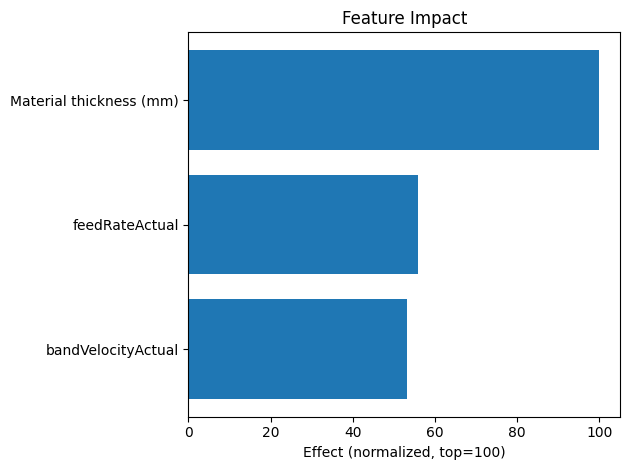

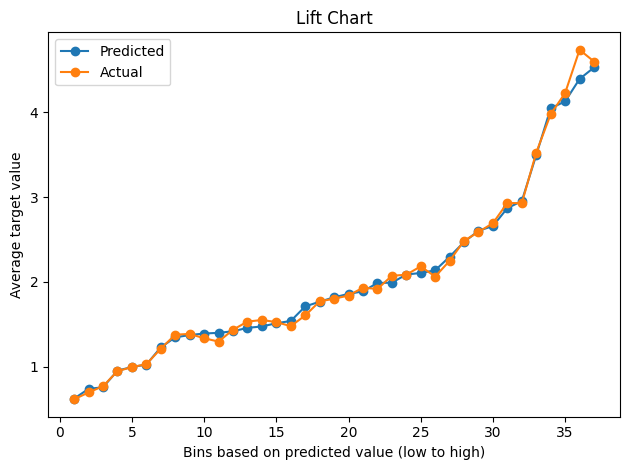

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance

# ============================================================
# CONFIG (edit here)
# ============================================================
DATA_PATH = "influxDB Backup/saw_wide_maschineRunning_true_joined.csv"
#DATA_PATH = "influxDB Backup/saw_wide_maschineRunning_true.csv"
TARGET = "currentRMS"  # Poisson requires y >= 0

# Place to exclude columns from modeling (as requested)
DROP_COLS = ["Experiment No", 
             "Piece No", 
             "time", 
             "Material",
             "temperatureRMS", 
             "machineRunning", 
             #"Material thickness (mm)",
             "microphoneRMS", 
             "vibrationRMS"]

RANDOM_STATE = 42
TEST_SIZE = 0.2

NUM_BOOST_ROUND = 20000
EARLY_STOP = 200

COARSE_TRIALS = 120   # increase if you want (autonomous, time not important)
REFINE_TRIALS = 80    # increase if you want

CV_SPLITS = 5

# For "real-time" mode (buffer + periodic reopt)
MAX_BUFFER_ROWS = 200_000
UPDATE_ADD_ROUNDS = 300
UPDATE_EARLY_STOP = 50
REOPTIMIZE_EVERY_UPDATES = 20   # set None to disable
REOPT_COARSE_TRIALS = 60
REOPT_REFINE_TRIALS = 40


# ============================================================
# Helpers (small and practical)
# ============================================================
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def predict_best(booster: xgb.Booster, dmat: xgb.DMatrix) -> np.ndarray:
    # Works across older/newer xgboost versions
    if hasattr(booster, "best_ntree_limit") and booster.best_ntree_limit:
        try:
            return booster.predict(dmat, ntree_limit=booster.best_ntree_limit)
        except TypeError:
            return booster.predict(dmat)
    if hasattr(booster, "best_iteration") and booster.best_iteration is not None:
        bi = int(booster.best_iteration) + 1
        try:
            return booster.predict(dmat, ntree_limit=bi)
        except TypeError:
            try:
                return booster.predict(dmat, iteration_range=(0, bi))
            except TypeError:
                return booster.predict(dmat)
    return booster.predict(dmat)

def make_features(df: pd.DataFrame, target: str, drop_cols: list[str], feature_cols=None):
    # Minimal preprocessing suitable for real-time: bool->int, one-hot, numeric, fillna(0), align columns.
    y = pd.to_numeric(df[target], errors="coerce") if target in df.columns else None
    X = df.drop(columns=[target] + [c for c in drop_cols if c in df.columns], errors="ignore").copy()

    for c in X.columns:
        if X[c].dtype == "bool":
            X[c] = X[c].astype(int)

    X = pd.get_dummies(X, drop_first=False)
    X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

    if feature_cols is not None:
        # Align to training feature space (unknown categories are dropped, missing are filled with 0)
        X = X.reindex(columns=feature_cols, fill_value=0)

    return X, y

def sample_params(rng: np.random.Generator, best=None):
    # Auto parameter sampling (coarse if best=None, otherwise refine around best)
    if best is None:
        eta = float(10 ** rng.uniform(-2.0, -0.3))               # ~[0.01, 0.50]
        max_depth = int(rng.integers(2, 11))                      # 2..10
        min_child_weight = float(10 ** rng.uniform(-0.3, 1.3))    # ~[0.5, 20]
        subsample = float(rng.uniform(0.5, 1.0))
        colsample_bytree = float(rng.uniform(0.5, 1.0))
        reg_lambda = float(10 ** rng.uniform(-3.0, 1.0))          # ~[0.001, 10]
        reg_alpha = 0.0 if rng.random() < 0.35 else float(10 ** rng.uniform(-3.0, 1.0))
        gamma = float(10 ** rng.uniform(-3.0, 0.7))               # ~[0.001, 5]
    else:
        # Refine: multiplicative jitter for continuous, +/- for depth
        eta = float(np.clip(best["eta"] * (10 ** rng.uniform(-0.35, 0.35)), 0.005, 0.5))
        max_depth = int(np.clip(best["max_depth"] + rng.integers(-2, 3), 2, 12))
        min_child_weight = float(np.clip(best["min_child_weight"] * (10 ** rng.uniform(-0.35, 0.35)), 0.1, 50))
        subsample = float(np.clip(best["subsample"] + rng.uniform(-0.15, 0.15), 0.5, 1.0))
        colsample_bytree = float(np.clip(best["colsample_bytree"] + rng.uniform(-0.15, 0.15), 0.5, 1.0))
        reg_lambda = float(np.clip(best["lambda"] * (10 ** rng.uniform(-0.5, 0.5)), 1e-6, 100))
        if best["alpha"] == 0.0 and rng.random() < 0.5:
            reg_alpha = 0.0
        else:
            base_a = best["alpha"] if best["alpha"] > 0 else 1e-3
            reg_alpha = float(np.clip(base_a * (10 ** rng.uniform(-0.6, 0.6)), 0.0, 100))
        gamma = float(np.clip(best["gamma"] * (10 ** rng.uniform(-0.6, 0.6)), 0.0, 20))

    return {
        "eta": eta,
        "max_depth": max_depth,
        "min_child_weight": min_child_weight,
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "lambda": reg_lambda,
        "alpha": reg_alpha,
        "gamma": gamma,
    }

def train_one(params, dtrain, dvalid):
    base_params = {
        "objective": "count:poisson",
        "eval_metric": "poisson-nloglik",
        "tree_method": "hist",
        "seed": RANDOM_STATE,
        "max_delta_step": 1,  # often stabilizes Poisson
    }
    full_params = {**base_params, **params}

    booster = xgb.train(
        params=full_params,
        dtrain=dtrain,
        num_boost_round=NUM_BOOST_ROUND,
        evals=[(dvalid, "valid")],
        early_stopping_rounds=EARLY_STOP,
        verbose_eval=False,
    )

    pred_valid = predict_best(booster, dvalid)
    pred_valid_pos = np.clip(pred_valid, 1e-12, None)
    score = float(mean_poisson_deviance(dvalid.get_label(), pred_valid_pos))
    return booster, score

def auto_search(dtrain, dvalid, coarse_trials, refine_trials, rng):
    best_params = None
    best_booster = None
    best_score = np.inf

    # coarse
    for _ in range(coarse_trials):
        p = sample_params(rng, best=None)
        booster, score = train_one(p, dtrain, dvalid)
        if score < best_score:
            best_score = score
            best_params = p
            best_booster = booster

    # refine around the best found
    for _ in range(refine_trials):
        p = sample_params(rng, best=best_params)
        booster, score = train_one(p, dtrain, dvalid)
        if score < best_score:
            best_score = score
            best_params = p
            best_booster = booster

    return best_params, best_booster, best_score


# ============================================================
# 1) Load + prepare dataset
# ============================================================
df = pd.read_csv(DATA_PATH)
df.columns = df.columns.str.strip()

X_all, y_all = make_features(df, TARGET, DROP_COLS, feature_cols=None)
y_all = pd.to_numeric(y_all, errors="coerce")

mask = y_all.notna()
X_all = X_all.loc[mask]
y_all = y_all.loc[mask]

if (y_all < 0).any():
    raise ValueError("Poisson objective requires target y >= 0 (no negative values).")

# Holdout split
X_tr, X_va, y_tr, y_va = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Align feature spaces
X_tr, X_va = X_tr.align(X_va, axis=1, join="left", fill_value=0)
FEATURE_COLS = list(X_tr.columns)

dtrain = xgb.DMatrix(X_tr, label=y_tr, feature_names=FEATURE_COLS)
dvalid = xgb.DMatrix(X_va, label=y_va, feature_names=FEATURE_COLS)

# ============================================================
# 2) Automatic hyperparameter search + early stopping
# ============================================================
rng = np.random.default_rng(RANDOM_STATE)
best_params, best_booster, best_poiss_dev = auto_search(
    dtrain, dvalid, COARSE_TRIALS, REFINE_TRIALS, rng
)

print("Best hyperparameters:", best_params)
print("Best validation Poisson deviance:", best_poiss_dev)
print("Best iteration:", getattr(best_booster, "best_iteration", None))

# ============================================================
# 3) Metrics: train / validation
# ============================================================
pred_tr = predict_best(best_booster, dtrain)
pred_va = predict_best(best_booster, dvalid)

train_rmse = rmse(y_tr, pred_tr)
train_r2 = float(r2_score(y_tr, pred_tr))

valid_rmse = rmse(y_va, pred_va)
valid_r2 = float(r2_score(y_va, pred_va))

print("\nTRAIN: RMSE =", train_rmse, " | R^2 =", train_r2)
print("VALID: RMSE =", valid_rmse, " | R^2 =", valid_r2)

# ============================================================
# 4) Cross-validation metrics (k-fold) using best hyperparameters
# ============================================================
kf = KFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

cv_rmses, cv_r2s = [], []

X_np = X_all.reindex(columns=FEATURE_COLS, fill_value=0).to_numpy()
y_np = y_all.to_numpy()

base_params_cv = {
    "objective": "count:poisson",
    "eval_metric": "poisson-nloglik",
    "tree_method": "hist",
    "seed": RANDOM_STATE,
    "max_delta_step": 1,
    **best_params,
}

for tr_idx, va_idx in kf.split(X_np):
    dtr = xgb.DMatrix(X_np[tr_idx], label=y_np[tr_idx], feature_names=FEATURE_COLS)
    dva = xgb.DMatrix(X_np[va_idx], label=y_np[va_idx], feature_names=FEATURE_COLS)

    booster = xgb.train(
        params=base_params_cv,
        dtrain=dtr,
        num_boost_round=NUM_BOOST_ROUND,
        evals=[(dva, "fold_valid")],
        early_stopping_rounds=EARLY_STOP,
        verbose_eval=False,
    )

    pred = predict_best(booster, dva)
    cv_rmses.append(rmse(y_np[va_idx], pred))
    cv_r2s.append(float(r2_score(y_np[va_idx], pred)))

print("\nCV (k-fold): RMSE mean/std =", float(np.mean(cv_rmses)), "/", float(np.std(cv_rmses)))
print("CV (k-fold): R^2  mean/std =", float(np.mean(cv_r2s)), "/", float(np.std(cv_r2s)))

# ============================================================
# 5) Plots: Feature Impact + Lift Chart
# ============================================================
gain_dict = best_booster.get_score(importance_type="gain")
gain = np.array([gain_dict.get(f, 0.0) for f in FEATURE_COLS], dtype=float)
impact = (gain / gain.max()) * 100.0 if gain.max() > 0 else gain

fi = (
    pd.DataFrame({"feature": FEATURE_COLS, "impact": impact})
    .sort_values("impact", ascending=False)
    .head(25)
)

plt.figure()
plt.barh(fi["feature"][::-1], fi["impact"][::-1])
plt.xlabel("Effect (normalized, top=100)")
plt.title("Feature Impact")
plt.tight_layout()
plt.show()

lift_df = pd.DataFrame({"pred": pred_va, "actual": y_va.values}).dropna()
lift_df["bin"] = pd.qcut(lift_df["pred"], q=60, labels=False, duplicates="drop")
lift = (
    lift_df.groupby("bin", as_index=False)
    .agg(pred_mean=("pred", "mean"), actual_mean=("actual", "mean"))
    .sort_values("bin")
)

x = np.arange(1, len(lift) + 1)
plt.figure()
plt.plot(x, lift["pred_mean"], marker="o", label="Predicted")
plt.plot(x, lift["actual_mean"], marker="o", label="Actual")
plt.xlabel("Bins based on predicted value (low to high)")
plt.ylabel("Average target value")
plt.title("Lift Chart")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 6) Real-time mode (autonomous): predict + online update + optional hyperparam reopt
# ============================================================
# We keep a rolling buffer of recent data to update model parameters over time.
buffer_X = X_tr.copy()
buffer_y = y_tr.copy()
update_counter = 0

def predict_batch(new_df: pd.DataFrame) -> np.ndarray:
    # Returns predictions for a new incoming batch (same preprocessing + feature alignment)
    X_new, _ = make_features(new_df, TARGET, DROP_COLS, feature_cols=FEATURE_COLS)
    dnew = xgb.DMatrix(X_new, feature_names=FEATURE_COLS)
    return predict_best(best_booster, dnew)

def update_with_new_batch(new_df: pd.DataFrame):
    # Updates model parameters by continuing training on buffered data (autonomous online adaptation)
    # new_df must include TARGET (for supervised update). If you don't have target yet, skip updating.
    global best_booster, buffer_X, buffer_y, update_counter

    X_new, y_new = make_features(new_df, TARGET, DROP_COLS, feature_cols=FEATURE_COLS)
    y_new = pd.to_numeric(y_new, errors="coerce")

    m = y_new.notna()
    X_new = X_new.loc[m]
    y_new = y_new.loc[m]

    if len(y_new) == 0:
        return

    if (y_new < 0).any():
        raise ValueError("Poisson objective requires y >= 0 in streaming target values.")

    buffer_X = pd.concat([buffer_X, X_new], axis=0).tail(MAX_BUFFER_ROWS)
    buffer_y = pd.concat([buffer_y, y_new], axis=0).tail(MAX_BUFFER_ROWS)

    d_buf = xgb.DMatrix(buffer_X, label=buffer_y, feature_names=FEATURE_COLS)
    d_val = dvalid  # keep the same validation holdout for stability; you can replace with rolling validation if needed

    params = {
        "objective": "count:poisson",
        "eval_metric": "poisson-nloglik",
        "tree_method": "hist",
        "seed": RANDOM_STATE,
        "max_delta_step": 1,
        **best_params,
    }

    best_booster = xgb.train(
        params=params,
        dtrain=d_buf,
        num_boost_round=UPDATE_ADD_ROUNDS,
        evals=[(d_val, "valid")],
        early_stopping_rounds=UPDATE_EARLY_STOP,
        verbose_eval=False,
        xgb_model=best_booster,   # continue training existing booster
    )

    update_counter += 1

def maybe_reoptimize():
    # Optional: adapt hyperparameters too (slow but fully autonomous).
    # Runs a smaller auto-search on the rolling buffer.
    global best_params, best_booster

    if REOPTIMIZE_EVERY_UPDATES is None:
        return
    if update_counter % REOPTIMIZE_EVERY_UPDATES != 0:
        return

    d_buf = xgb.DMatrix(buffer_X, label=buffer_y, feature_names=FEATURE_COLS)
    # Use the same holdout validation (or build your own rolling validation set)
    p, b, s = auto_search(d_buf, dvalid, REOPT_COARSE_TRIALS, REOPT_REFINE_TRIALS, rng=np.random.default_rng(RANDOM_STATE + update_counter))

    best_params, best_booster = p, b
    print("\n[REOPT] New best hyperparameters:", best_params)
    print("[REOPT] New validation Poisson deviance:", s)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
best: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.8}
train rmse/r2: 0.5460982190494228 0.7050217766526432
valid rmse/r2: 0.5299218260664966 0.7362900171680504
valid poisson dev: 0.1412275876938728


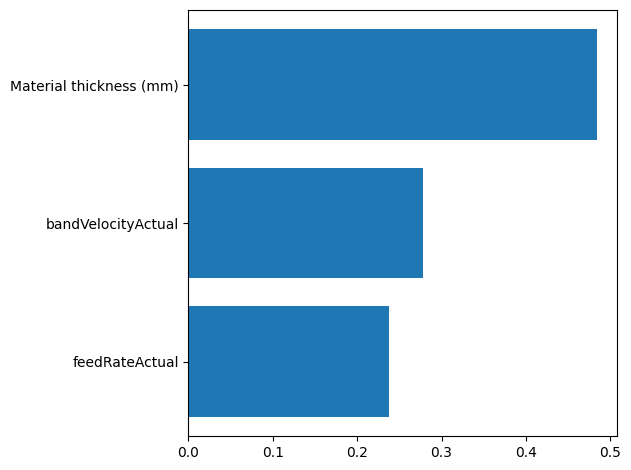

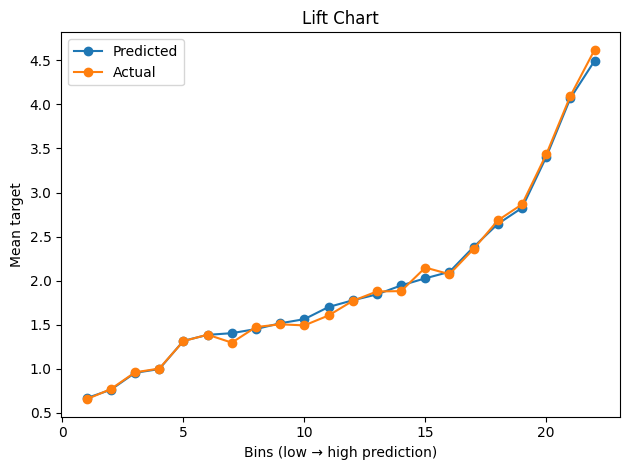

In [11]:
import numpy as np, pandas as pd, xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance

DATA_PATH = "influxDB Backup/saw_wide_maschineRunning_true_joined.csv"
TARGET = "currentRMS"
DROP_COLS = ["Experiment No","Piece No","time","Material","temperatureRMS","machineRunning","microphoneRMS","vibrationRMS"]
RANDOM_STATE = 42

df = pd.read_csv(DATA_PATH)
y = pd.to_numeric(df[TARGET], errors="coerce")
X = df.drop(columns=[TARGET] + [c for c in DROP_COLS if c in df.columns], errors="ignore")

m = y.notna()
X, y = X.loc[m], y.loc[m]
if (y < 0).any(): raise ValueError("Poisson needs y>=0")

X = pd.get_dummies(X, drop_first=False).apply(pd.to_numeric, errors="coerce").fillna(0)

Xtr, Xva, ytr, yva = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
Xtr, Xva = Xtr.align(Xva, axis=1, join="left", fill_value=0)

model = xgb.XGBRegressor(objective="count:poisson", tree_method="hist", eval_metric="poisson-nloglik",
                         random_state=RANDOM_STATE, n_jobs=-1)

grid = {
    "n_estimators":[400,800],
    "learning_rate":[0.05,0.1],
    "max_depth":[3,5],
    "subsample":[0.8,1.0],
    "colsample_bytree":[0.8,1.0],
}
gs = GridSearchCV(model, grid, scoring="neg_mean_poisson_deviance", cv=5, n_jobs=-1, verbose=1)
gs.fit(Xtr, ytr)

best = gs.best_estimator_
p_tr, p_va = best.predict(Xtr), best.predict(Xva)

print("best:", gs.best_params_)
print("train rmse/r2:", np.sqrt(mean_squared_error(ytr,p_tr)), r2_score(ytr,p_tr))
print("valid rmse/r2:", np.sqrt(mean_squared_error(yva,p_va)), r2_score(yva,p_va))
print("valid poisson dev:", mean_poisson_deviance(yva, np.clip(p_va,1e-12,None)))

# Feature importance (top 15)
imp = best.feature_importances_
top = np.argsort(imp)[-15:]
plt.figure()
plt.barh(Xtr.columns[top], imp[top])
plt.tight_layout()
plt.show()

# Lift chart (bins by predicted value)
lift = pd.DataFrame({"pred": p_va, "actual": yva.to_numpy()}).dropna()
lift["bin"] = pd.qcut(lift["pred"], q=30, labels=False, duplicates="drop")
g = lift.groupby("bin").agg(pred_mean=("pred","mean"), actual_mean=("actual","mean")).sort_index()

x = np.arange(1, len(g) + 1)
plt.figure()
plt.plot(x, g["pred_mean"], marker="o", label="Predicted")
plt.plot(x, g["actual_mean"], marker="o", label="Actual")
plt.xlabel("Bins (low → high prediction)")
plt.ylabel("Mean target")
plt.title("Lift Chart")
plt.legend()
plt.tight_layout()
plt.show()


config

In [12]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd

TARGET_CURRENT = 1.7

BAND_COL = "bandVelocityActual"
FEED_COL = "feedRateActual"

BAND_BOUNDS = (13.0, 104.0)   # set real machine limits
FEED_BOUNDS = (3.0, 137.0) # set real machine limits

Optimization (offset + SciPy minimize)

In [13]:
def _X(row: dict) -> pd.DataFrame:
    # Uses the SAME preprocessing as training: get_dummies + align to FEATURE_COLS
    df1 = pd.DataFrame([row]).reindex(columns=RAW_FEATURE_COLS)
    x1 = pd.get_dummies(df1, drop_first=False).apply(pd.to_numeric, errors="coerce").fillna(0)
    return x1.reindex(columns=FEATURE_COLS, fill_value=0)

def suggest_settings(row: dict, measured_current=None, prev_offset=0.0, alpha=0.8, w_change=0.02):
    # 1) expected current
    c_exp_cur = float(best.predict(_X(row))[0])

    # 2) offset = c_act - c_exp (EMA smoothed)
    if measured_current is None:
        offset = float(prev_offset)
    else:
        offset = alpha * float(prev_offset) + (1 - alpha) * (float(measured_current) - c_exp_cur)

    b0, f0 = float(row[BAND_COL]), float(row[FEED_COL])
    bs = max(BAND_BOUNDS[1] - BAND_BOUNDS[0], 1e-9)
    fs = max(FEED_BOUNDS[1] - FEED_BOUNDS[0], 1e-9)

    def obj(z):
        b, f = float(z[0]), float(z[1])
        r = dict(row); r[BAND_COL] = b; r[FEED_COL] = f
        c_est = float(best.predict(_X(r))[0]) + offset
        err = TARGET_CURRENT - c_est
        reg = w_change * (((b - b0) / bs) ** 2 + ((f - f0) / fs) ** 2)
        return float(err * err + reg)

    res = minimize(obj, x0=[b0, f0], method="L-BFGS-B", bounds=[BAND_BOUNDS, FEED_BOUNDS])

    b_opt, f_opt = float(res.x[0]), float(res.x[1])
    r = dict(row); r[BAND_COL] = b_opt; r[FEED_COL] = f_opt
    c_est_opt = float(best.predict(_X(r))[0]) + offset

    return {"band_opt": b_opt, "feed_opt": f_opt, "offset": offset, "c_est_opt": c_est_opt, "ok": bool(res.success)}

Example usage (live loop idea)

In [ ]:
offset = 0.0

row = {
    BAND_COL: 25.0,
    FEED_COL: 300.0,
    "Material thickness (mm)": 10.0,  # change to your real column name
}

measured_current = 1.9  # from sensor right now (or None)

out = suggest_settings(row, measured_current=measured_current, prev_offset=offset)
offset = out["offset"]

print(out)  # operator applies band_opt / feed_opt